In [1]:
import os
import time
import numpy as np
import random

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split, Subset
from torch.optim import lr_scheduler



# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [2]:
from song_code_reproduction.src.mnist_fcn import FCN_parameters, FCModel, LEARNING_RATE, WEIGHT_DECAY
# from song_code_reproduction.src.sign_loss import SignEncodingCriterion, reconstruct_bytes_from_model

from song_code_reproduction.src.sign_encoding_loss import (
    SignEncodingPenalty,
    select_all_params,
    bytes_to_images_torch,
    capacity_report,
)


In [3]:
save_path = "/dt/yisroel/Users/Data_Memorization/song_memorization/SIGN/mnist"

memorization_size = 100

# Training Params
BATCH_SIZE = 128
num_epochs = 100 # Example number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
# Define transformations for training with augmentation
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Define transformations for validation, testing, and memorization set (no augmentation)
eval_transform = transforms.Compose([
    transforms.ToTensor(),
])

mem_transform = transforms.Compose([])


# Download the full CIFAR100 training dataset
full_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=eval_transform)


# Split the full training set into training and validation indices
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
train_indices, val_indices = random_split(range(len(full_trainset)), [train_size, val_size])

# Create training and validation datasets using indices and applying appropriate transforms
train_dataset = Subset(full_trainset, train_indices.indices)
val_dataset = Subset(full_trainset, val_indices.indices)

# Apply transforms to the datasets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = eval_transform

if memorization_size > len(full_trainset):
    memorization_size = len(full_trainset)
memorization_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)

memorization_indices = torch.randperm(len(full_trainset))[:memorization_size].tolist()
memorization_set = Subset(memorization_set, memorization_indices)

# Create DataLoaders
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)


print("DataLoaders created successfully!")
print(f"Number of images in training set: {len(train_dataset)}")
print(f"Number of images in validation set: {len(val_dataset)}")
print(f"Number of images in test set: {len(testset)}")
print(f"Number of images in memorization set: {len(memorization_set)}")

DataLoaders created successfully!
Number of images in training set: 48000
Number of images in validation set: 12000
Number of images in test set: 10000
Number of images in memorization set: 100


In [5]:
model = FCModel(**FCN_parameters).to(device)

In [6]:
criterion = nn.CrossEntropyLoss()

sign_penalty = SignEncodingPenalty(
    model=model,
    dataset=memorization_set,
    subset_selector=select_all_params,
    lambda_max=50.0,
    margin=1e-3,
    redundancy_k=5,         # IMPORTANT: maximize capacity for visible recon
    device=device,
    float_mode="clip01",
)
print(capacity_report(sign_penalty, bits_per_image=28*28*8))


optimizer = optim.AdamW(model.parameters(), lr= 5e-4, weight_decay=0)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

print("Training hyperparameters and objects defined.")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Number of Epochs: {num_epochs}")
print(f"Loss Function: {type(criterion).__name__}")
print(f"Optimizer Type: {type(optimizer).__name__}")
print(f"Scheduler Type: {type(scheduler).__name__}")
print(f"Device: {device}")

Capacity: subset L=3962890, redundancy k=5, available bits B=627200, fits ~100 images
Training hyperparameters and objects defined.
Learning Rate: 0.0001
Number of Epochs: 100
Loss Function: CrossEntropyLoss
Optimizer Type: AdamW
Scheduler Type: CosineAnnealingLR
Device: cuda


In [7]:
def train_batch(images, labels, model, optimizer, criterion, step, total_steps, device):
    images, labels = images.to(device), labels.to(device)

    # Forward pass
    outputs = model(images)
    sign_pen = sign_penalty(step, total_steps)
    # print(sign_pen)
    loss = criterion(outputs, labels) + sign_pen
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    return loss.item()

def evaluate_batch(images, labels, model, criterion, device):
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # Calculate accuracy
      _, predicted = torch.max(outputs.data, 1)
      correct = (predicted == labels).sum().item()

    return loss.item(), correct, labels.size(0)

def main_train_loop(model, trainloader, valloader, optimizer, criterion, scheduler, num_epochs, device, save_path):
    best_train_loss = float('inf')

    model.train()
    total_steps = num_epochs * len(trainloader)
    step = 0
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        start_time = time.time()

        # Training phase
        for i, (images, labels) in enumerate(trainloader):
            loss = train_batch(images, labels, model, optimizer, criterion, step, total_steps, device)
            running_loss += loss
            step += 1

        epoch_loss = running_loss / len(trainloader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        for images, labels in valloader:
            loss, correct, total = evaluate_batch(images, labels, model, criterion, device)
            val_loss += loss
            correct_predictions += correct
            total_predictions += total

        epoch_val_loss = val_loss / len(valloader)
        accuracy = correct_predictions / total_predictions

        end_time = time.time()
        epoch_time = end_time - start_time

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, '
              f'Val Accuracy: {accuracy:.4f}, '
              f'Epoch Time: {epoch_time:.2f}s')

        # Step the scheduler
        scheduler.step()

        # Save the model with lowest training loss
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            model_save_path = os.path.join(save_path, 'best_model.pth')
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved best model to {model_save_path} with training loss: {best_train_loss:.4f}")

        model.train() # Set model back to training mode
        model_save_path = os.path.join(save_path, 'last_model.pth')
        torch.save(model.state_dict(), model_save_path)
    print('Finished Training')

In [8]:
# main_train_loop(model, trainloader, valloader, optimizer, criterion, scheduler, num_epochs, device, save_path)

## Test model after training

In [31]:
import torch
import os

# Define the path to the saved model
save_path = "/dt/yisroel/Users/Data_Memorization/song_memorization/SIGN/mnist"
model_save_path = os.path.join(save_path, 'last_model.pth')

# Instantiate the model (make sure the model architecture is defined in a previous cell)
# Assuming 'model' is already defined and is an instance of your ViT class
# model = VisionTransformer(...) # If not already defined, define it here with the correct parameters

# Load the saved state dictionary
if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path))
    print(f"Model loaded successfully from {model_save_path}")
else:
    print(f"No model found at {model_save_path}")

# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model is on device: {next(model.parameters()).device}")

Model loaded successfully from /dt/yisroel/Users/Data_Memorization/song_memorization/SIGN/mnist/last_model.pth
Model is on device: cuda:0


In [32]:
import torch

def test_model(model, testloader, device):
    # Set the model to evaluation mode
    model.eval()

    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Iterate over the test data
    with torch.no_grad():
        for images, labels in testloader:
            loss, correct, total = evaluate_batch(images, labels, model, criterion, device)
            test_loss += loss
            correct_predictions += correct
            total_predictions += total

    # Calculate average test loss and accuracy
    average_test_loss = test_loss / len(testloader)
    test_accuracy = correct_predictions / total_predictions

    print(f'Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

## SIGN encoding test

In [33]:
from song_code_reproduction.src.ssim_eval import ssim
from song_code_reproduction.src.pruning import prune_model_global_l1
from song_code_reproduction.src.sign_encoding_loss import (select_all_params, bytes_to_images_torch,
                                                           decode_bytes_from_given_model, bytes_to_images_torch)



Decoded bytes: 78400 → can reconstruct up to 100 images
Reconstructed tensor: torch.Size([100, 1, 28, 28]) torch.uint8 0 255


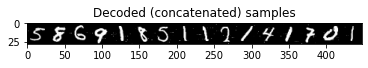

In [34]:
# ----- Decode images -----
decoded = sign_penalty.decode_bytes_from_model()

H, W, C, order = 28, 28, 1, "CHW"
per_image_bytes = H * W * C  # 784
max_images = len(decoded) // per_image_bytes
print(f"Decoded bytes: {len(decoded)} → can reconstruct up to {max_images} images")

N = min(memorization_size, max_images)
if N == 0:
    print("Not enough capacity for a full image. Increase subset size or reduce redundancy.")
else:
    imgs = bytes_to_images_torch(decoded, n=N, h=H, w=W, c=C, order=order, device="cpu")
    print("Reconstructed tensor:", imgs.shape, imgs.dtype, imgs.min().item(), imgs.max().item())
    # Optionally visualize
    import matplotlib.pyplot as plt
    grid = torch.cat([imgs[i] for i in range(min(16, N))], dim=2)[0]
    plt.imshow(grid.numpy(), cmap="gray")
    plt.title("Decoded (concatenated) samples")
    plt.show()
    
    
def decode(model, sign_penalty, size = (28, 28, 1), order="CHW"):
    
    subset_selector = select_all_params     # or select_linear_head_params — must match training
    k = sign_penalty.k
    B_bits = int(sign_penalty.B_bits.item())
    
    decoded = decode_bytes_from_given_model(
        model=model,
        subset_selector=subset_selector,
        k=k,
        B_bits=B_bits,
    )
    
    # 3) Turn bytes into images (MNIST shapes)
    H, W, C, order = 28, 28, 1, "CHW"
    per_image_bytes = H * W * C

    max_images = len(decoded) // per_image_bytes

    imgs = bytes_to_images_torch(decoded, n=max_images, h=H, w=W, c=C, order=order, device="cpu")
    return imgs


In [35]:
imgs[0].size()

torch.Size([1, 28, 28])

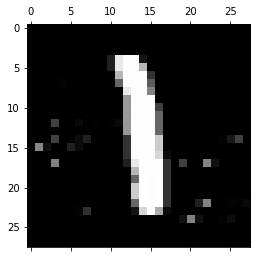

In [36]:
from matplotlib import pyplot as plt

plt.matshow((imgs[4].reshape(28,28)), cmap='gray')
plt.show()


In [37]:
def calc_ssim(memorization_set, recon, memorization_size):
    ssim_scores = []
    for i in range(len(recon)):
        with torch.no_grad():
            ext_img = recon[i].unsqueeze(0).to(torch.float32)
            src_img = torch.tensor(np.array(memorization_set[i][0])).view(1, 1, 28, 28).to(torch.float32)
            ssim_score = 0.5*(ssim(ext_img, src_img)+1)
            ssim_scores.append(ssim_score)
    ssim_scores = torch.tensor(ssim_scores)
    return ssim_scores.mean()

In [38]:
imgs = decode(model, sign_penalty)
ssim_before_pruning = calc_ssim(memorization_set, imgs, memorization_size)
print("Before pruning:")
print(f"SSIM: {ssim_before_pruning:.4f}")
test_model(model, testloader, device)

pruned_model = prune_model_global_l1(model, 0.2)
print()

print("After pruning:")
imgs = decode(pruned_model, sign_penalty)
ssim_after_pruning = calc_ssim(memorization_set, imgs, memorization_size)
print(f"SSIM: {ssim_after_pruning:.4f}")
test_model(pruned_model, testloader, device)

Before pruning:
SSIM: 0.9892
Test Loss: 0.1114, Test Accuracy: 0.9796

After pruning:
SSIM: 0.5385
Test Loss: 0.1151, Test Accuracy: 0.9808
